Diabetic Retinopathy Classifier

This jupyter notebook demonstrate the application of DenseNet121 to classify diabetic retinopathy 
fundus images.

__author__ = "Jianfei Liu"

__copyright__ = "Copyright 2023, Diabetic Retinopathy Project"

__credits__ = ["Jianfei Liu"]

__license__ = "GPL"

__version__ = "1.0"

__maintainer__ = "Jianfei Liu"

__email__ = "jianfei.liu@nih.gov"

__status__ = "Development"


# DenseNet-121 Diabetic Retinopathy Classifier

### Introduction

The Kaggle Diabetic Retinopathy (DR) dataset [1] is a color fundus image database. This database was provided by EyePACS, and fundus images were caputured under various conditions by differrent devices at multiple primary care sites. For each subject, two images of the left and left eyes were collected. A clinician was asked to rate each image for the presence of DR with a scale of 0–4 according to the Early Treatment Diabetic Retinopathy Study (ETDRS) scale. The downloading link [1] only contains 35,126 images that were originally used as the training dataset. In this task, I will rearrage these images, and split them into training, validation, and testing data. 

The purpose of this task is to develop a classifer to automatically decide the scale of the presence of DR for a fundus image, similar to what the clinician did. The DenseNet is used to serve this purpose because it achieves the high claissficiation accuracy with a resonable computational cost. 

### Network Architecture

The network in this notebook is an implementation of the DenseNet-121 [1] architecture to train a retinopathy classifier. It classifies the input fundus image into the presence of diabetic retinopathy with a scale of 0–4. 

The pipeline of the DenseNet is illustrated in below. In each "dense" block, each layer is connected with each previous layer -- the feature maps are concatenated.

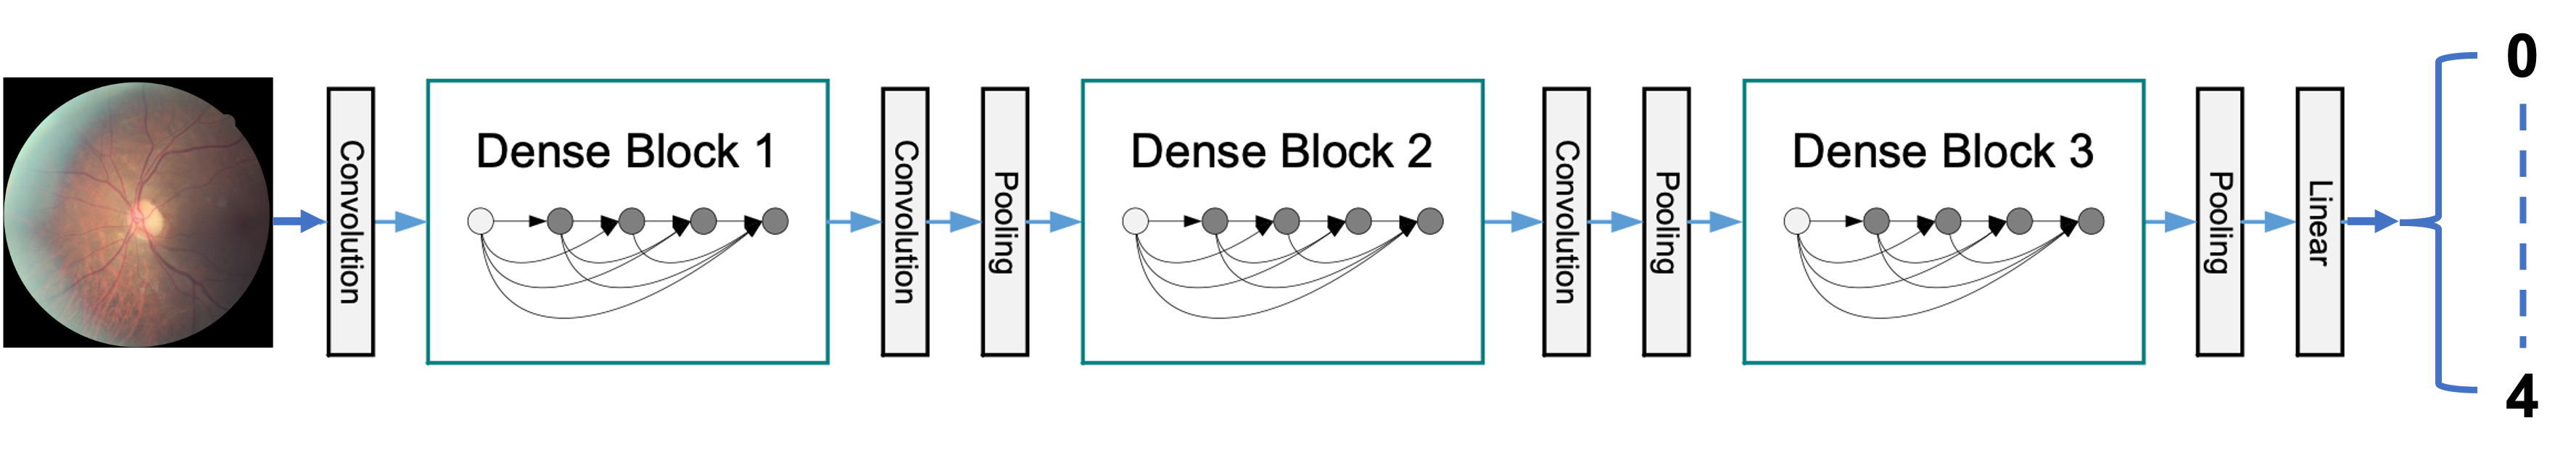
Figure 1: A deep DenseNet with three dense blocks. The layers between two adjacent blocks are referred to as transition layers and change feature-map sizes via convolution and pooling (modified from Fig. 2 in [1]).

Let $H_l(\cdot)$ be a composite function of operations sucha as Batch Normalization (BN), rectified linear units (ReLU), Pooling, or Convolution (Conv). We denote the output of the $l^{th}$ layer of $\mathbf{x}_l$. In DenseNets, all previous feature maps $\mathbf{x}_0, \ldots, \mathbf{x}_{l-1}$ of a feature map $\mathbf{x}_l$ are concatenated.
$$\mathbf{x}_l = H_l(\mathbf{x}_0, \mathbf{x}_1, \ldots, \mathbf{x}_{l-1})$$
There are multiple types of DenseNets in the original paper [1], and the DenseNet-121 is used in this work for its least computational cost. 

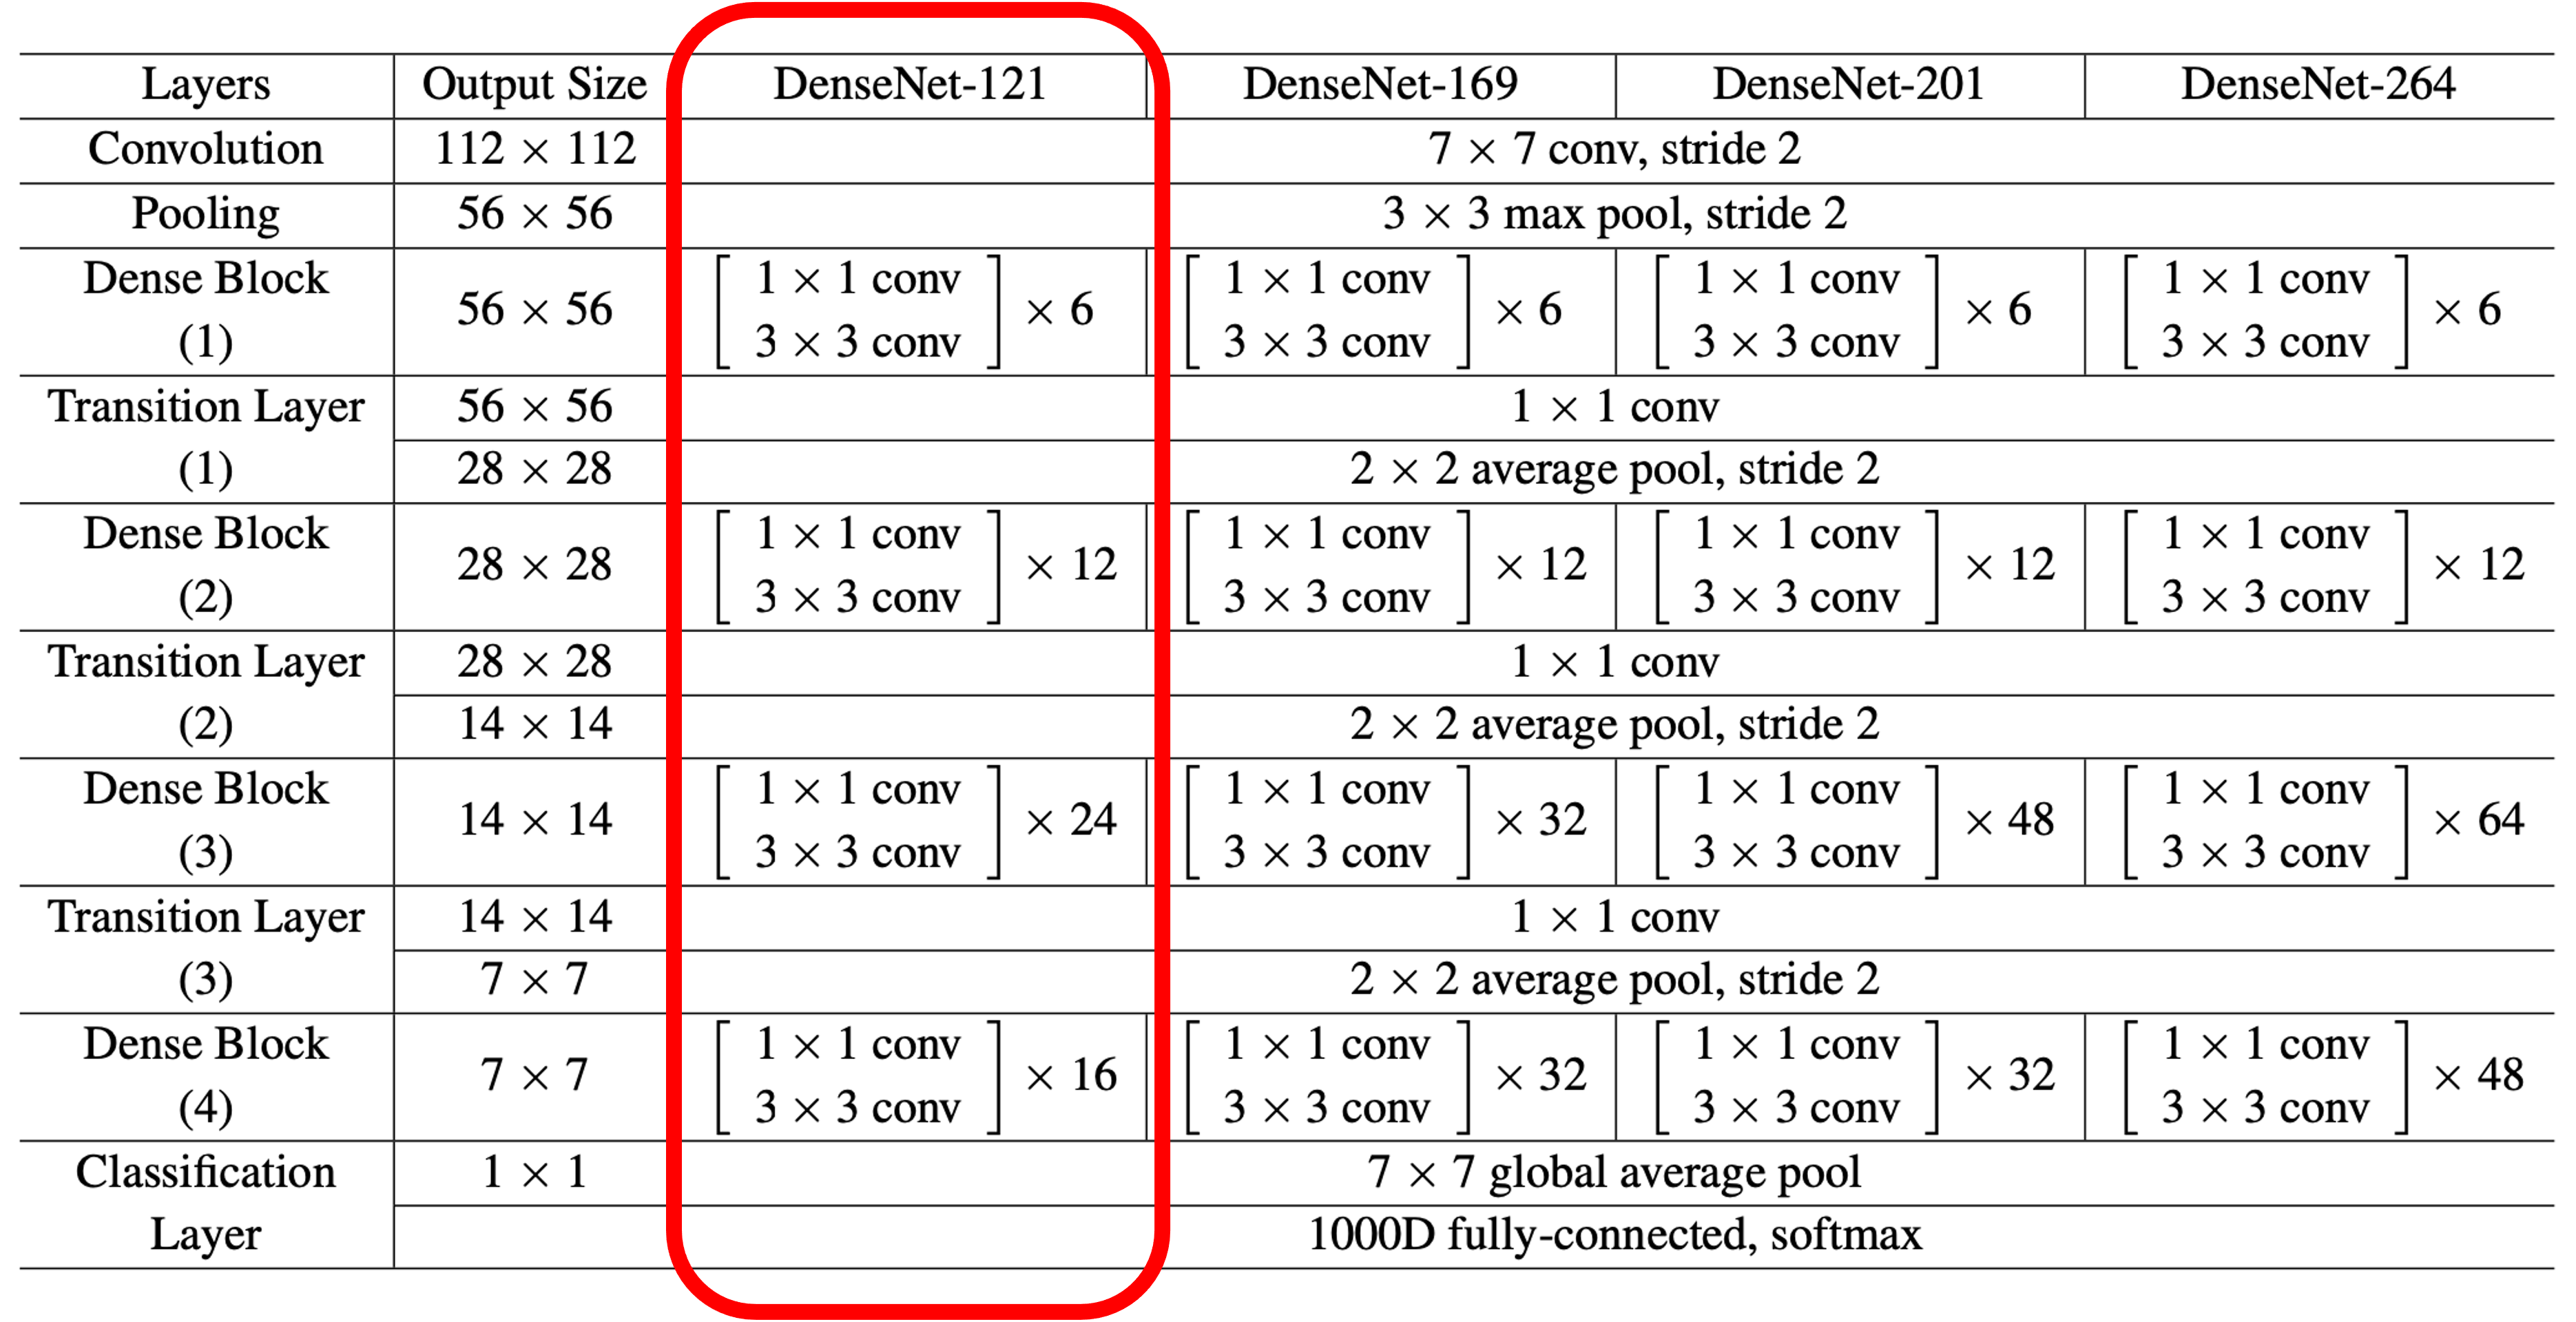
Table 1: DenseNet architectures for ImageNet. The growth rate for all the networks is k = 32. Note that each “conv” layer shown in the table corresponds the sequence BN-ReLU-Conv. In this work, the DenseNet-121 is used. 

#### Reference

[1] Kaggle Diabetic Retinopathy dataset. https://www.kaggle.com/datasets/mariaherrerot/eyepacspreprocess

[2] G. Huang, Z. Liu, L. Van Der Maaten, and K. Q. Weinberger. Densely Connected Convolutional Networks. In IEEE Conference on Computer Vision and Pattern Recognition (CVPR), 2017. https://openaccess.thecvf.com/content_cvpr_2017/html/Huang_Densely_Connected_Convolutional_CVPR_2017_paper.html

### Imports

In [43]:
import os
import time

import numpy as np
import pandas as pd
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Subset

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.io import read_image

from typing import Any, Dict, Iterator, List, Optional, Tuple

import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image
from pathlib import Path


if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

### Model Settings

In [44]:
##########################
### SETTINGS
##########################

# Hyperparameters
RANDOM_SEED = 42
LEARNING_RATE = 0.0001
BATCH_SIZE = 8
NUM_EPOCHS = 5

# Data set
IMAGE_SIZE = 256

# Architecture
NUM_CLASSES = 5

# Other
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Diabetic Retinopathy Dataset

#### Dataset Exploration

DR dataset is put in the same fold as the "DR-classification.ipynb" file.
The directory structure of DR dataset is formulated as

dataset/ 

         ├── trainLabels.csv
         │   
         └── eyepacs_preprocess
                ├── 10_left.jpeg
                ├── 10_right.jpeg
                └── ...
                └── 44349_right.jpeg


In [45]:
##display the first 6 records in the label file
df=pd.read_csv('dataset/trainLabels.csv')
df.head(6)

,image,level
0,10_left,0
1,10_right,0
2,13_left,0
3,13_right,0
4,15_left,1
5,15_right,2


In [46]:
##get the number of image labels
df.shape

(35108, 2)

In [47]:
##Calculate the statistics of image labels
df.describe()

,level
count,35108.000000
mean,0.525863
std,0.970372
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,4.000000


In [48]:
##get the set of unique image labels
df.level.unique()

array([0, 1, 2, 4, 3], dtype=int64)

Text(0, 0.5, 'Number of image labels')

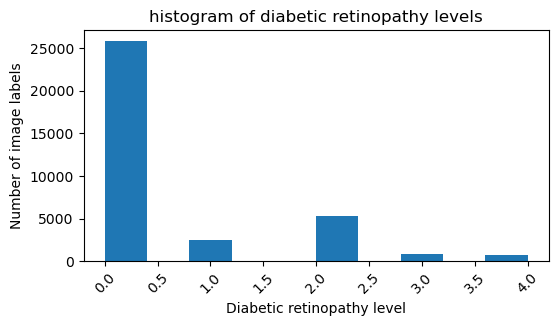

In [49]:
# check if DR levels are balanced..
df.level.plot(kind='hist', title='histogram of diabetic retinopathy levels', 
        rot=45, figsize=(6,3), fontsize=10, legend=False)
plt.xlabel('Diabetic retinopathy level')
plt.ylabel('Number of image labels')

In [50]:
# print out the number of labels of each level
df.level.value_counts()

0    25802
2     5288
1     2438
3      872
4      708
Name: level, dtype: int64

In [51]:
##check if the number of DR levels is matched with the number of input funduse images
fundus_img_filenames=[f for f in os.listdir('dataset/eyepacs_preprocess') if f.endswith('.jpeg')]
print(len(fundus_img_filenames))

35108


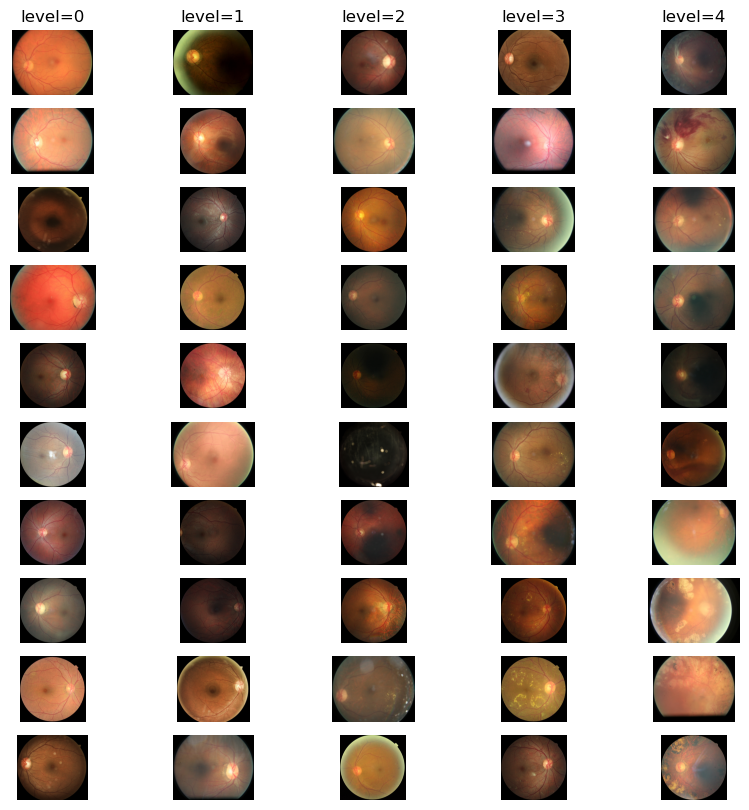

In [52]:
# Since the numbers of fundus images and labels are matched, now we can now safly and randomly display 50 
# Randomly search for 10 image file names per level
# Read images and display them
# f, axarr = plt.subplots(10, 5)
# for ax in axarr:
#     ax.set_axis_off()

fig = plt.figure(figsize=(10, 10))
df_indices = df.index
for level in range(5):
    #get the indices of series elements equal to level
    cur_indices = df['level'] == level
    res_indices = df_indices[cur_indices]
    
    #randomly select 10 indices from the res_indices
    selected_indices = random.choices(res_indices, k=10)
    for i, id in enumerate(selected_indices):
        img_path = os.path.join('dataset/eyepacs_preprocess', df.image[id] + '.jpeg')
        img = Image.open(img_path) 
        imgarr = np.array(img) 
        
        # we set "level+i*5+1" to index subplot to make sure 10 images of 
        # each column corrresponding to one level of diabetic retinopathy.
        # Note the addtion of "1" in "level+i*5+1" because "add_subplot" starts with 1
        fig.add_subplot(10, 5, level+i*5+1)
        plt.imshow(imgarr)
        plt.axis('off')
        
        # Add the level number on top of each column
        if i == 0:
            plt.title('level=' + str(level))

#### Dataset Selection (Training/Validation/Test)

In [53]:
# Stratified shuffle split is chosen to split data due to class imbalance
from sklearn.model_selection import StratifiedShuffleSplit

# first split the whole data set into train_validation data and test data
X=df.image
Y=df.level
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
train_val_index, test_index = next(sss.split(X, Y))

# get lists of test image names and labels first
test_image_names=df.image[test_index]
test_labels = df.level[test_index]


# second split train_validation data into training data and test data
X= df.image[train_val_index]
Y=df.level[train_val_index]
train_index, val_index = next(sss.split(X, Y))

train_image_names = df.image[train_index]
train_labels = df.level[train_index]

val_image_names = df.image[val_index]
val_labels = df.level[val_index]

print(train_image_names)
print(val_image_names)
print(test_image_names)

25053    31731_right
17066    21445_right
30001    37965_right
31102     39344_left
31047    39281_right
            ...     
24342     30779_left
2939       3646_left
26089     33031_left
27894     35344_left
17239     21654_left
Name: image, Length: 28437, dtype: object
23702     29963_left
1169       1432_left
24295    30714_right
30149    38165_right
26979     34170_left
            ...     
31161    39398_right
20577    25956_right
18525    23367_right
3509      4390_right
2662      3329_right
Name: image, Length: 3160, dtype: object
24440     30910_left
31936     40348_left
2132      2652_right
14063     17675_left
12271     15419_left
            ...     
1378       1722_left
15665    19614_right
30870     39045_left
22593    28530_right
29476     37340_left
Name: image, Length: 3511, dtype: object


#### Dataset Definition

In [54]:
class DRDataset(torch.utils.data.Dataset):
    """`Diabetic Retinopathy Classification Dataset.
    Args:
        root (string): Root directory of the Image Dataset.
        image_names (list): The list of image file names used used for DRDataset.
            These image files should also under root directory.
        image_labels (list): Corresponding list of image labels. 
        transform (callable, optional): A function/transform that  takes in an PIL image
            and returns a transformed version. E.g, ``transforms.RandomCrop``
     Return:
        (sample, target) (tuples) where target is class_index of the target class
    """

    def __init__(self, root: str, image_names: list, image_labels: list, 
                 transform = None) -> None:
        self.root = root
        
        if type(image_names) == list:
            self.image_names = image_names
        else:
            raise TypeError('The datatype of image_names is {}, not list'.format(type(image_names)))
            
        if type(image_labels) == list:
            self.image_labels = image_labels
        else:
            raise TypeError('The datatype of image_labels is {}, not list'.format(type(image_names)))
            
        self.transform = transform

    def __getitem__(self, index: int) -> Tuple[Any, Any]:
        """
        Args:
            index (int): Index

        Returns:
            tuple: (sample, target) where target is class_index of the target class.
        """
        img_path = os.path.join(self.root, self.image_names[index] + '.jpeg')
        image = Image.open(img_path)
        label = self.image_labels[index]
        
        if self.transform:
            image = self.transform(image)
            
        return image, label, self.image_names[index]


    def __len__(self) -> int:
        return len(self.image_labels)

#### Dataset Setup (Training/Validation/Test )

In [55]:
# visualization function to check if training or validation loader can properly yield a batch of data
def visualize_batch(batch, dataset_type):
    # initialize a figure
    fig = plt.figure("{} batch".format(dataset_type),
                     figsize=(BATCH_SIZE, BATCH_SIZE/2))
    
    # loop over the batch size
    for i in range(0, BATCH_SIZE):
        # create a subplot
        ax = plt.subplot(2, 4, i + 1)
        
        # grab the image, convert it from channels first ordering to
        # channels last ordering, and scale the raw pixel intensities
        # to the range [0, 255]
        image = batch[0][i].cpu().numpy()
        image = image.transpose((1, 2, 0))
        image = (image * 255.0).astype("uint8")
        
        # grab the label id and get the label from the classes list
        label = batch[1][i]
        plt.imshow(image)
        plt.title('level=' + str(label) + ", \n" + batch[2][i])
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()

training batch images


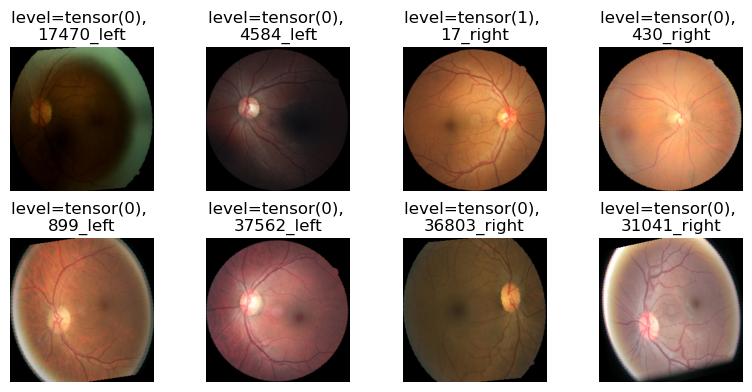





validation batch images




testing batch images


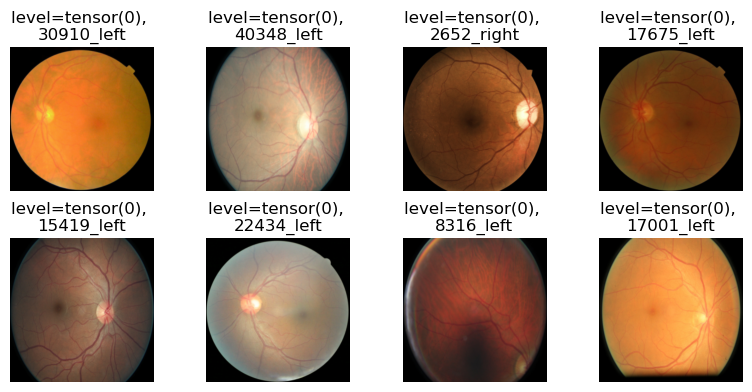

In [56]:
# define data augmentation

resize = transforms.Resize(size=(IMAGE_SIZE, IMAGE_SIZE))
hFlip = transforms.RandomHorizontalFlip(p=0.25)
vFlip = transforms.RandomVerticalFlip(p=0.25)
rotate = transforms.RandomRotation(degrees=15)

train_transform = transforms.Compose([resize, hFlip, vFlip, rotate,
                                      transforms.ToTensor()])
valid_transform = transforms.Compose([resize, transforms.ToTensor()])

# define training, validation, and test dataset
train_dataset = DRDataset(root='dataset/eyepacs_preprocess', 
                          image_names=train_image_names.tolist(),
                          image_labels=train_labels.tolist(),
                          transform=train_transform)
valid_dataset = DRDataset(root='dataset/eyepacs_preprocess', 
                          image_names=val_image_names.tolist(),
                          image_labels=val_labels.tolist(),
                          transform=valid_transform)
test_dataset = DRDataset(root='dataset/eyepacs_preprocess', 
                         image_names=test_image_names.tolist(),
                         image_labels=test_labels.tolist(),
                         transform=valid_transform)

# define data loader
train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=BATCH_SIZE,
                          num_workers=0,
                          shuffle=True)

valid_loader = DataLoader(dataset=valid_dataset, 
                          batch_size=BATCH_SIZE,
                          num_workers=0,
                          shuffle=False)

test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=BATCH_SIZE,
                         num_workers=0,
                         shuffle=False)

print('training batch images')
train_batch = next(iter(train_loader))
visualize_batch(train_batch, 'training')
print('============================================================')
print('============================================================')

print('\n\n\n')
print('validation batch images')
valid_batch = next(iter(valid_loader))
visualize_batch(valid_batch, 'validation')
print('============================================================')
print('============================================================')

print('\n\n\n')
print('testing batch images')
test_batch = next(iter(test_loader))
visualize_batch(test_batch, 'testing')
print('============================================================')
print('============================================================')

### DenseNet Implementation

In [57]:
class DensNet(nn.Module):
    def __init__(self, num_classes=5, num_channels=3, weights=None):
        super().__init__()
        preloaded = torchvision.models.densenet121(weights=weights)
        self.features = preloaded.features
        self.features.conv0 = nn.Conv2d(num_channels, 64, 7, 2, 3)
        self.classifier = nn.Linear(1024, num_classes, bias=True)
        del preloaded
        
    def forward(self, x):
        features = self.features(x)
        out = F.relu(features, inplace=True)
        out = F.adaptive_avg_pool2d(out, (1, 1)).view(features.size(0), -1)
        logits = self.classifier(out)
        probas = F.softmax(logits, dim=1)
        return logits, probas

### Training

#### Training setup

In [58]:
torch.manual_seed(RANDOM_SEED)
classes = 5
model = DensNet(num_classes=classes)
model.to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [59]:
# define a weighted loss function since training labels are imbalanced
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(class_weight='balanced', 
                                     classes=np.unique(train_labels), 
                                     y=train_labels)
# convert class_weights to tensor
class_weights = torch.from_numpy(class_weights).float()
print(class_weights)

tensor([0.2726, 2.8739, 1.3239, 7.9212, 9.7722])


In [ ]:
# for unknown reason, this function is not working..

# def compute_acc(model, data_loader, device):
#     correct_pred, num_examples = 0, 0
#     for i, (images, labels, paths) in enumerate(data_loader):
            
#         images = images.to(device)
#         labels = labels.to(device)

#         logits, probas = model(images)
#         _, predicted_labels = torch.max(probas, 1)
#         num_examples += labels.size(0)
#         assert predicted_labels.size() == labels.size()
#         correct_pred += (predicted_labels == labels).sum()
        
#         if not batch_idx % 10:
#             print (f'Batch {i:03d}/{len(data_loader):03d} | acc: {correct_pred.float()/num_examples * 100:.2f}')
            
#     return correct_pred.float()/num_examples * 100


start_time = time.time()

cost_list = []
train_acc_list, valid_acc_list = [], []
best_valid_acc = 0
print('Device: {}'.format(DEVICE) )
for epoch in range(NUM_EPOCHS):
    
    model.train()
    for batch_idx, (images, labels, paths) in enumerate(train_loader):
        
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
            
        ### FORWARD AND BACK PROP
        logits, probas = model(images)
        cost = F.cross_entropy(logits, labels, class_weights.to(DEVICE))
        optimizer.zero_grad()
        
        cost.backward()
        
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        #################################################
        ### CODE ONLY FOR LOGGING BEYOND THIS POINT
        ################################################
        cost_list.append(cost.item())
        if not batch_idx % 10:
            print (f'Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d} | '
                   f'Batch {batch_idx:03d}/{len(train_loader):03d} |' 
                   f' Cost: {cost:.4f}')

        

    model.eval()
    with torch.set_grad_enabled(False): # save memory during inference
        
        #training acc
        correct_pred, num_examples = 0, 0
        for i, (images, labels, paths) in enumerate(train_loader):
            
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)

            logits, probas = model(images)
            _, predicted_labels = torch.max(probas, 1)
            num_examples += labels.size(0)
            assert predicted_labels.size() == labels.size()
            correct_pred += (predicted_labels == labels).sum()
            cur_train_acc = correct_pred.float()/num_examples * 100
            print (f'Batch {i:03d}/{len(train_loader):03d} | Training ACC: {cur_train_acc:.2f}')
            
        train_acc = correct_pred.float()/num_examples * 100
        train_acc_list.append(train_acc.detach().cpu().numpy())
        
        #validation acc         
        correct_pred, num_examples = 0, 0
        for i, (images, labels, paths) in enumerate(valid_loader):
            
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)

            logits, probas = model(images)
            _, predicted_labels = torch.max(probas, 1)
            num_examples += labels.size(0)
            assert predicted_labels.size() == labels.size()
            correct_pred += (predicted_labels == labels).sum()
            cur_valid_acc = correct_pred.float()/num_examples * 100
            print (f'Batch {i:03d}/{len(valid_loader):03d} | Validation ACC: {cur_valid_acc:.2f}')
            
        valid_acc = correct_pred.float()/num_examples * 100
        valid_acc_list.append(valid_acc.detach().cpu().numpy())
        
        # always save the model weights with the best          
        if valid_acc > best_valid_acc:
            best_valid_acc = valid_acc
            print(best_valid_acc)
            Path("weights").mkdir(parents=True, exist_ok=True)
            model_file_name = os.path.join('weights', 'DRClassifcation.pth')
            
            torch.save({'epoch': epoch, 'state_dict': model.state_dict(), 'best_acc': best_valid_acc}, 
                       model_file_name)
            
        
#         train_acc = compute_acc(model, train_loader, device=DEVICE)
#         valid_acc = compute_acc(model, valid_loader, device=DEVICE)

        print(f'Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d}\n'
              f'Train ACC: {train_acc:.2f} | Validation ACC: {valid_acc:.2f}')
        
    elapsed = (time.time() - start_time)/60
    print(f'Time elapsed: {elapsed:.2f} min')
  
elapsed = (time.time() - start_time)/60
print(f'Total Training Time: {elapsed:.2f} min')

Device: cuda
Epoch: 001/005 | Batch 000/3555 | Cost: 1.5930
Epoch: 001/005 | Batch 010/3555 | Cost: 1.4844
Epoch: 001/005 | Batch 020/3555 | Cost: 2.0869
Epoch: 001/005 | Batch 030/3555 | Cost: 2.2805
Epoch: 001/005 | Batch 040/3555 | Cost: 1.2869
Epoch: 001/005 | Batch 050/3555 | Cost: 1.1296
Epoch: 001/005 | Batch 060/3555 | Cost: 2.5237
Epoch: 001/005 | Batch 070/3555 | Cost: 1.3898
Epoch: 001/005 | Batch 080/3555 | Cost: 1.1447
Epoch: 001/005 | Batch 090/3555 | Cost: 1.2619
Epoch: 001/005 | Batch 100/3555 | Cost: 1.3538
Epoch: 001/005 | Batch 110/3555 | Cost: 1.6097
Epoch: 001/005 | Batch 120/3555 | Cost: 1.5637
Epoch: 001/005 | Batch 130/3555 | Cost: 2.0041
Epoch: 001/005 | Batch 140/3555 | Cost: 1.4587
Epoch: 001/005 | Batch 150/3555 | Cost: 1.0841
Epoch: 001/005 | Batch 160/3555 | Cost: 1.1682
Epoch: 001/005 | Batch 170/3555 | Cost: 1.7806
Epoch: 001/005 | Batch 180/3555 | Cost: 1.1190
Epoch: 001/005 | Batch 190/3555 | Cost: 2.2219
Epoch: 001/005 | Batch 200/3555 | Cost: 1.2823


Epoch: 001/005 | Batch 1730/3555 | Cost: 1.3647
Epoch: 001/005 | Batch 1740/3555 | Cost: 1.8204
Epoch: 001/005 | Batch 1750/3555 | Cost: 1.9653
Epoch: 001/005 | Batch 1760/3555 | Cost: 1.9302
Epoch: 001/005 | Batch 1770/3555 | Cost: 1.4181
Epoch: 001/005 | Batch 1780/3555 | Cost: 1.9277
Epoch: 001/005 | Batch 1790/3555 | Cost: 1.1423
Epoch: 001/005 | Batch 1800/3555 | Cost: 1.4229
Epoch: 001/005 | Batch 1810/3555 | Cost: 1.8623
Epoch: 001/005 | Batch 1820/3555 | Cost: 1.6328
Epoch: 001/005 | Batch 1830/3555 | Cost: 1.4610
Epoch: 001/005 | Batch 1840/3555 | Cost: 1.2995
Epoch: 001/005 | Batch 1850/3555 | Cost: 1.9660
Epoch: 001/005 | Batch 1860/3555 | Cost: 1.4327
Epoch: 001/005 | Batch 1870/3555 | Cost: 1.2304
Epoch: 001/005 | Batch 1880/3555 | Cost: 1.3911
Epoch: 001/005 | Batch 1890/3555 | Cost: 2.0557
Epoch: 001/005 | Batch 1900/3555 | Cost: 1.4290
Epoch: 001/005 | Batch 1910/3555 | Cost: 1.4833
Epoch: 001/005 | Batch 1920/3555 | Cost: 1.3915
Epoch: 001/005 | Batch 1930/3555 | Cost:

Epoch: 001/005 | Batch 3440/3555 | Cost: 1.0063
Epoch: 001/005 | Batch 3450/3555 | Cost: 1.9170
Epoch: 001/005 | Batch 3460/3555 | Cost: 1.9274
Epoch: 001/005 | Batch 3470/3555 | Cost: 1.4912
Epoch: 001/005 | Batch 3480/3555 | Cost: 1.2288
Epoch: 001/005 | Batch 3490/3555 | Cost: 2.1465
Epoch: 001/005 | Batch 3500/3555 | Cost: 1.3835
Epoch: 001/005 | Batch 3510/3555 | Cost: 1.3058
Epoch: 001/005 | Batch 3520/3555 | Cost: 1.0416
Epoch: 001/005 | Batch 3530/3555 | Cost: 1.8837
Epoch: 001/005 | Batch 3540/3555 | Cost: 1.3671
Epoch: 001/005 | Batch 3550/3555 | Cost: 2.0100
Batch 000/3555 | Training ACC: 50.00
Batch 001/3555 | Training ACC: 56.25
Batch 002/3555 | Training ACC: 50.00
Batch 003/3555 | Training ACC: 46.88
Batch 004/3555 | Training ACC: 52.50
Batch 005/3555 | Training ACC: 54.17
Batch 006/3555 | Training ACC: 55.36
Batch 007/3555 | Training ACC: 54.69
Batch 008/3555 | Training ACC: 54.17
Batch 009/3555 | Training ACC: 53.75
Batch 010/3555 | Training ACC: 53.41
Batch 011/3555 | 

Batch 206/3555 | Training ACC: 57.37
Batch 207/3555 | Training ACC: 57.45
Batch 208/3555 | Training ACC: 57.60
Batch 209/3555 | Training ACC: 57.44
Batch 210/3555 | Training ACC: 57.29
Batch 211/3555 | Training ACC: 57.25
Batch 212/3555 | Training ACC: 57.22
Batch 213/3555 | Training ACC: 57.18
Batch 214/3555 | Training ACC: 57.15
Batch 215/3555 | Training ACC: 57.18
Batch 216/3555 | Training ACC: 57.20
Batch 217/3555 | Training ACC: 57.17
Batch 218/3555 | Training ACC: 57.25
Batch 219/3555 | Training ACC: 57.27
Batch 220/3555 | Training ACC: 57.30
Batch 221/3555 | Training ACC: 57.26
Batch 222/3555 | Training ACC: 57.40
Batch 223/3555 | Training ACC: 57.31
Batch 224/3555 | Training ACC: 57.17
Batch 225/3555 | Training ACC: 57.13
Batch 226/3555 | Training ACC: 57.21
Batch 227/3555 | Training ACC: 57.29
Batch 228/3555 | Training ACC: 57.26
Batch 229/3555 | Training ACC: 57.28
Batch 230/3555 | Training ACC: 57.25
Batch 231/3555 | Training ACC: 57.27
Batch 232/3555 | Training ACC: 57.35
B

Batch 428/3555 | Training ACC: 57.17
Batch 429/3555 | Training ACC: 57.12
Batch 430/3555 | Training ACC: 57.08
Batch 431/3555 | Training ACC: 57.09
Batch 432/3555 | Training ACC: 57.10
Batch 433/3555 | Training ACC: 57.11
Batch 434/3555 | Training ACC: 57.13
Batch 435/3555 | Training ACC: 57.05
Batch 436/3555 | Training ACC: 57.09
Batch 437/3555 | Training ACC: 57.11
Batch 438/3555 | Training ACC: 57.03
Batch 439/3555 | Training ACC: 57.05
Batch 440/3555 | Training ACC: 57.09
Batch 441/3555 | Training ACC: 57.10
Batch 442/3555 | Training ACC: 57.11
Batch 443/3555 | Training ACC: 57.07
Batch 444/3555 | Training ACC: 57.05
Batch 445/3555 | Training ACC: 57.03
Batch 446/3555 | Training ACC: 57.07
Batch 447/3555 | Training ACC: 57.11
Batch 448/3555 | Training ACC: 57.10
Batch 449/3555 | Training ACC: 57.14
Batch 450/3555 | Training ACC: 57.12
Batch 451/3555 | Training ACC: 57.13
Batch 452/3555 | Training ACC: 57.12
Batch 453/3555 | Training ACC: 57.16
Batch 454/3555 | Training ACC: 57.17
B

Batch 650/3555 | Training ACC: 57.12
Batch 651/3555 | Training ACC: 57.13
Batch 652/3555 | Training ACC: 57.12
Batch 653/3555 | Training ACC: 57.15
Batch 654/3555 | Training ACC: 57.14
Batch 655/3555 | Training ACC: 57.18
Batch 656/3555 | Training ACC: 57.17
Batch 657/3555 | Training ACC: 57.18
Batch 658/3555 | Training ACC: 57.17
Batch 659/3555 | Training ACC: 57.16
Batch 660/3555 | Training ACC: 57.15
Batch 661/3555 | Training ACC: 57.18
Batch 662/3555 | Training ACC: 57.18
Batch 663/3555 | Training ACC: 57.17
Batch 664/3555 | Training ACC: 57.14
Batch 665/3555 | Training ACC: 57.15
Batch 666/3555 | Training ACC: 57.12
Batch 667/3555 | Training ACC: 57.13
Batch 668/3555 | Training ACC: 57.12
Batch 669/3555 | Training ACC: 57.09
Batch 670/3555 | Training ACC: 57.08
Batch 671/3555 | Training ACC: 57.07
Batch 672/3555 | Training ACC: 57.06
Batch 673/3555 | Training ACC: 57.03
Batch 674/3555 | Training ACC: 56.96
Batch 675/3555 | Training ACC: 56.99
Batch 676/3555 | Training ACC: 57.00
B

Batch 873/3555 | Training ACC: 57.42
Batch 874/3555 | Training ACC: 57.44
Batch 875/3555 | Training ACC: 57.45
Batch 876/3555 | Training ACC: 57.47
Batch 877/3555 | Training ACC: 57.46
Batch 878/3555 | Training ACC: 57.48
Batch 879/3555 | Training ACC: 57.49
Batch 880/3555 | Training ACC: 57.49
Batch 881/3555 | Training ACC: 57.48
Batch 882/3555 | Training ACC: 57.47
Batch 883/3555 | Training ACC: 57.49
Batch 884/3555 | Training ACC: 57.50
Batch 885/3555 | Training ACC: 57.51
Batch 886/3555 | Training ACC: 57.51
Batch 887/3555 | Training ACC: 57.52
Batch 888/3555 | Training ACC: 57.54
Batch 889/3555 | Training ACC: 57.50
Batch 890/3555 | Training ACC: 57.49
Batch 891/3555 | Training ACC: 57.54
Batch 892/3555 | Training ACC: 57.53
Batch 893/3555 | Training ACC: 57.55
Batch 894/3555 | Training ACC: 57.54
Batch 895/3555 | Training ACC: 57.53
Batch 896/3555 | Training ACC: 57.57
Batch 897/3555 | Training ACC: 57.57
Batch 898/3555 | Training ACC: 57.58
Batch 899/3555 | Training ACC: 57.58
B

Batch 1092/3555 | Training ACC: 57.40
Batch 1093/3555 | Training ACC: 57.40
Batch 1094/3555 | Training ACC: 57.39
Batch 1095/3555 | Training ACC: 57.40
Batch 1096/3555 | Training ACC: 57.40
Batch 1097/3555 | Training ACC: 57.39
Batch 1098/3555 | Training ACC: 57.40
Batch 1099/3555 | Training ACC: 57.40
Batch 1100/3555 | Training ACC: 57.39
Batch 1101/3555 | Training ACC: 57.42
Batch 1102/3555 | Training ACC: 57.41
Batch 1103/3555 | Training ACC: 57.43
Batch 1104/3555 | Training ACC: 57.41
Batch 1105/3555 | Training ACC: 57.40
Batch 1106/3555 | Training ACC: 57.38
Batch 1107/3555 | Training ACC: 57.40
Batch 1108/3555 | Training ACC: 57.39
Batch 1109/3555 | Training ACC: 57.41
Batch 1110/3555 | Training ACC: 57.39
Batch 1111/3555 | Training ACC: 57.40
Batch 1112/3555 | Training ACC: 57.41
Batch 1113/3555 | Training ACC: 57.42
Batch 1114/3555 | Training ACC: 57.41
Batch 1115/3555 | Training ACC: 57.41
Batch 1116/3555 | Training ACC: 57.40
Batch 1117/3555 | Training ACC: 57.42
Batch 1118/3

Batch 1308/3555 | Training ACC: 57.15
Batch 1309/3555 | Training ACC: 57.15
Batch 1310/3555 | Training ACC: 57.15
Batch 1311/3555 | Training ACC: 57.13
Batch 1312/3555 | Training ACC: 57.14
Batch 1313/3555 | Training ACC: 57.14
Batch 1314/3555 | Training ACC: 57.14
Batch 1315/3555 | Training ACC: 57.14
Batch 1316/3555 | Training ACC: 57.15
Batch 1317/3555 | Training ACC: 57.15
Batch 1318/3555 | Training ACC: 57.15
Batch 1319/3555 | Training ACC: 57.14
Batch 1320/3555 | Training ACC: 57.14
Batch 1321/3555 | Training ACC: 57.16
Batch 1322/3555 | Training ACC: 57.15
Batch 1323/3555 | Training ACC: 57.17
Batch 1324/3555 | Training ACC: 57.16
Batch 1325/3555 | Training ACC: 57.16
Batch 1326/3555 | Training ACC: 57.15
Batch 1327/3555 | Training ACC: 57.14
Batch 1328/3555 | Training ACC: 57.14
Batch 1329/3555 | Training ACC: 57.15
Batch 1330/3555 | Training ACC: 57.16
Batch 1331/3555 | Training ACC: 57.15
Batch 1332/3555 | Training ACC: 57.14
Batch 1333/3555 | Training ACC: 57.14
Batch 1334/3

Batch 1524/3555 | Training ACC: 57.34
Batch 1525/3555 | Training ACC: 57.35
Batch 1526/3555 | Training ACC: 57.36
Batch 1527/3555 | Training ACC: 57.35
Batch 1528/3555 | Training ACC: 57.36
Batch 1529/3555 | Training ACC: 57.37
Batch 1530/3555 | Training ACC: 57.38
Batch 1531/3555 | Training ACC: 57.38
Batch 1532/3555 | Training ACC: 57.36
Batch 1533/3555 | Training ACC: 57.36
Batch 1534/3555 | Training ACC: 57.36
Batch 1535/3555 | Training ACC: 57.36
Batch 1536/3555 | Training ACC: 57.35
Batch 1537/3555 | Training ACC: 57.36
Batch 1538/3555 | Training ACC: 57.37
Batch 1539/3555 | Training ACC: 57.37
Batch 1540/3555 | Training ACC: 57.36
Batch 1541/3555 | Training ACC: 57.36
Batch 1542/3555 | Training ACC: 57.36
Batch 1543/3555 | Training ACC: 57.38
Batch 1544/3555 | Training ACC: 57.36
Batch 1545/3555 | Training ACC: 57.37
Batch 1546/3555 | Training ACC: 57.34
Batch 1547/3555 | Training ACC: 57.34
Batch 1548/3555 | Training ACC: 57.35
Batch 1549/3555 | Training ACC: 57.36
Batch 1550/3

Batch 1740/3555 | Training ACC: 57.24
Batch 1741/3555 | Training ACC: 57.25
Batch 1742/3555 | Training ACC: 57.24
Batch 1743/3555 | Training ACC: 57.24
Batch 1744/3555 | Training ACC: 57.23
Batch 1745/3555 | Training ACC: 57.25
Batch 1746/3555 | Training ACC: 57.26
Batch 1747/3555 | Training ACC: 57.26
Batch 1748/3555 | Training ACC: 57.26
Batch 1749/3555 | Training ACC: 57.26
Batch 1750/3555 | Training ACC: 57.26
Batch 1751/3555 | Training ACC: 57.26
Batch 1752/3555 | Training ACC: 57.24
Batch 1753/3555 | Training ACC: 57.25
Batch 1754/3555 | Training ACC: 57.26
Batch 1755/3555 | Training ACC: 57.28
Batch 1756/3555 | Training ACC: 57.29
Batch 1757/3555 | Training ACC: 57.28
Batch 1758/3555 | Training ACC: 57.26
Batch 1759/3555 | Training ACC: 57.27
Batch 1760/3555 | Training ACC: 57.25
Batch 1761/3555 | Training ACC: 57.24
Batch 1762/3555 | Training ACC: 57.25
Batch 1763/3555 | Training ACC: 57.26
Batch 1764/3555 | Training ACC: 57.26
Batch 1765/3555 | Training ACC: 57.26
Batch 1766/3

Batch 1957/3555 | Training ACC: 57.21
Batch 1958/3555 | Training ACC: 57.20
Batch 1959/3555 | Training ACC: 57.20
Batch 1960/3555 | Training ACC: 57.20
Batch 1961/3555 | Training ACC: 57.21
Batch 1962/3555 | Training ACC: 57.21
Batch 1963/3555 | Training ACC: 57.21
Batch 1964/3555 | Training ACC: 57.19
Batch 1965/3555 | Training ACC: 57.19
Batch 1966/3555 | Training ACC: 57.18
Batch 1967/3555 | Training ACC: 57.19
Batch 1968/3555 | Training ACC: 57.18
Batch 1969/3555 | Training ACC: 57.19
Batch 1970/3555 | Training ACC: 57.20
Batch 1971/3555 | Training ACC: 57.21
Batch 1972/3555 | Training ACC: 57.21
Batch 1973/3555 | Training ACC: 57.21
Batch 1974/3555 | Training ACC: 57.22
Batch 1975/3555 | Training ACC: 57.22
Batch 1976/3555 | Training ACC: 57.21
Batch 1977/3555 | Training ACC: 57.23
Batch 1978/3555 | Training ACC: 57.23
Batch 1979/3555 | Training ACC: 57.22
Batch 1980/3555 | Training ACC: 57.21
Batch 1981/3555 | Training ACC: 57.23
Batch 1982/3555 | Training ACC: 57.25
Batch 1983/3

Batch 2173/3555 | Training ACC: 57.18
Batch 2174/3555 | Training ACC: 57.18
Batch 2175/3555 | Training ACC: 57.17
Batch 2176/3555 | Training ACC: 57.16
Batch 2177/3555 | Training ACC: 57.15
Batch 2178/3555 | Training ACC: 57.15
Batch 2179/3555 | Training ACC: 57.15
Batch 2180/3555 | Training ACC: 57.16
Batch 2181/3555 | Training ACC: 57.16
Batch 2182/3555 | Training ACC: 57.17
Batch 2183/3555 | Training ACC: 57.17
Batch 2184/3555 | Training ACC: 57.19
Batch 2185/3555 | Training ACC: 57.18
Batch 2186/3555 | Training ACC: 57.17
Batch 2187/3555 | Training ACC: 57.16
Batch 2188/3555 | Training ACC: 57.16
Batch 2189/3555 | Training ACC: 57.16
Batch 2190/3555 | Training ACC: 57.17
Batch 2191/3555 | Training ACC: 57.17
Batch 2192/3555 | Training ACC: 57.17
Batch 2193/3555 | Training ACC: 57.17
Batch 2194/3555 | Training ACC: 57.18
Batch 2195/3555 | Training ACC: 57.18
Batch 2196/3555 | Training ACC: 57.19
Batch 2197/3555 | Training ACC: 57.19
Batch 2198/3555 | Training ACC: 57.21
Batch 2199/3

Batch 2389/3555 | Training ACC: 57.21
Batch 2390/3555 | Training ACC: 57.21
Batch 2391/3555 | Training ACC: 57.21
Batch 2392/3555 | Training ACC: 57.22
Batch 2393/3555 | Training ACC: 57.21
Batch 2394/3555 | Training ACC: 57.19
Batch 2395/3555 | Training ACC: 57.18
Batch 2396/3555 | Training ACC: 57.18
Batch 2397/3555 | Training ACC: 57.17
Batch 2398/3555 | Training ACC: 57.15
Batch 2399/3555 | Training ACC: 57.16
Batch 2400/3555 | Training ACC: 57.16
Batch 2401/3555 | Training ACC: 57.16
Batch 2402/3555 | Training ACC: 57.16
Batch 2403/3555 | Training ACC: 57.16
Batch 2404/3555 | Training ACC: 57.15
Batch 2405/3555 | Training ACC: 57.14
Batch 2406/3555 | Training ACC: 57.15
Batch 2407/3555 | Training ACC: 57.16
Batch 2408/3555 | Training ACC: 57.17
Batch 2409/3555 | Training ACC: 57.15
Batch 2410/3555 | Training ACC: 57.15
Batch 2411/3555 | Training ACC: 57.14
Batch 2412/3555 | Training ACC: 57.14
Batch 2413/3555 | Training ACC: 57.15
Batch 2414/3555 | Training ACC: 57.14
Batch 2415/3

Batch 2606/3555 | Training ACC: 57.05
Batch 2607/3555 | Training ACC: 57.06
Batch 2608/3555 | Training ACC: 57.06
Batch 2609/3555 | Training ACC: 57.06
Batch 2610/3555 | Training ACC: 57.06
Batch 2611/3555 | Training ACC: 57.05
Batch 2612/3555 | Training ACC: 57.06
Batch 2613/3555 | Training ACC: 57.04
Batch 2614/3555 | Training ACC: 57.05
Batch 2615/3555 | Training ACC: 57.05
Batch 2616/3555 | Training ACC: 57.06
Batch 2617/3555 | Training ACC: 57.05
Batch 2618/3555 | Training ACC: 57.05
Batch 2619/3555 | Training ACC: 57.05
Batch 2620/3555 | Training ACC: 57.04
Batch 2621/3555 | Training ACC: 57.04
Batch 2622/3555 | Training ACC: 57.03
Batch 2623/3555 | Training ACC: 57.04
Batch 2624/3555 | Training ACC: 57.04
Batch 2625/3555 | Training ACC: 57.05
Batch 2626/3555 | Training ACC: 57.04
Batch 2627/3555 | Training ACC: 57.04
Batch 2628/3555 | Training ACC: 57.05
Batch 2629/3555 | Training ACC: 57.05
Batch 2630/3555 | Training ACC: 57.04
Batch 2631/3555 | Training ACC: 57.04
Batch 2632/3

Batch 2822/3555 | Training ACC: 57.01
Batch 2823/3555 | Training ACC: 57.01
Batch 2824/3555 | Training ACC: 57.02
Batch 2825/3555 | Training ACC: 57.01
Batch 2826/3555 | Training ACC: 57.01
Batch 2827/3555 | Training ACC: 57.01
Batch 2828/3555 | Training ACC: 57.01
Batch 2829/3555 | Training ACC: 57.01
Batch 2830/3555 | Training ACC: 57.01
Batch 2831/3555 | Training ACC: 57.02
Batch 2832/3555 | Training ACC: 57.02
Batch 2833/3555 | Training ACC: 57.03
Batch 2834/3555 | Training ACC: 57.02
Batch 2835/3555 | Training ACC: 57.01
Batch 2836/3555 | Training ACC: 57.01
Batch 2837/3555 | Training ACC: 57.02
Batch 2838/3555 | Training ACC: 57.02
Batch 2839/3555 | Training ACC: 57.02
Batch 2840/3555 | Training ACC: 57.01
Batch 2841/3555 | Training ACC: 57.02
Batch 2842/3555 | Training ACC: 57.03
Batch 2843/3555 | Training ACC: 57.03
Batch 2844/3555 | Training ACC: 57.04
Batch 2845/3555 | Training ACC: 57.05
Batch 2846/3555 | Training ACC: 57.05
Batch 2847/3555 | Training ACC: 57.05
Batch 2848/3

Batch 3038/3555 | Training ACC: 56.99
Batch 3039/3555 | Training ACC: 56.99
Batch 3040/3555 | Training ACC: 56.99
Batch 3041/3555 | Training ACC: 57.00
Batch 3042/3555 | Training ACC: 57.00
Batch 3043/3555 | Training ACC: 57.00
Batch 3044/3555 | Training ACC: 56.99
Batch 3045/3555 | Training ACC: 56.98
Batch 3046/3555 | Training ACC: 56.99
Batch 3047/3555 | Training ACC: 57.00
Batch 3048/3555 | Training ACC: 57.00
Batch 3049/3555 | Training ACC: 57.00
Batch 3050/3555 | Training ACC: 57.01
Batch 3051/3555 | Training ACC: 57.00
Batch 3052/3555 | Training ACC: 57.01
Batch 3053/3555 | Training ACC: 57.01
Batch 3054/3555 | Training ACC: 57.00
Batch 3055/3555 | Training ACC: 57.01
Batch 3056/3555 | Training ACC: 57.00
Batch 3057/3555 | Training ACC: 57.00
Batch 3058/3555 | Training ACC: 57.00
Batch 3059/3555 | Training ACC: 57.00
Batch 3060/3555 | Training ACC: 57.01
Batch 3061/3555 | Training ACC: 57.01
Batch 3062/3555 | Training ACC: 57.01
Batch 3063/3555 | Training ACC: 57.01
Batch 3064/3

Batch 3254/3555 | Training ACC: 57.11
Batch 3255/3555 | Training ACC: 57.11
Batch 3256/3555 | Training ACC: 57.11
Batch 3257/3555 | Training ACC: 57.11
Batch 3258/3555 | Training ACC: 57.10
Batch 3259/3555 | Training ACC: 57.10
Batch 3260/3555 | Training ACC: 57.10
Batch 3261/3555 | Training ACC: 57.09
Batch 3262/3555 | Training ACC: 57.10
Batch 3263/3555 | Training ACC: 57.10
Batch 3264/3555 | Training ACC: 57.09
Batch 3265/3555 | Training ACC: 57.10
Batch 3266/3555 | Training ACC: 57.10
Batch 3267/3555 | Training ACC: 57.10
Batch 3268/3555 | Training ACC: 57.10
Batch 3269/3555 | Training ACC: 57.09
Batch 3270/3555 | Training ACC: 57.10
Batch 3271/3555 | Training ACC: 57.09
Batch 3272/3555 | Training ACC: 57.10
Batch 3273/3555 | Training ACC: 57.10
Batch 3274/3555 | Training ACC: 57.10
Batch 3275/3555 | Training ACC: 57.11
Batch 3276/3555 | Training ACC: 57.12
Batch 3277/3555 | Training ACC: 57.12
Batch 3278/3555 | Training ACC: 57.12
Batch 3279/3555 | Training ACC: 57.12
Batch 3280/3

Batch 3470/3555 | Training ACC: 57.14
Batch 3471/3555 | Training ACC: 57.14
Batch 3472/3555 | Training ACC: 57.14
Batch 3473/3555 | Training ACC: 57.14
Batch 3474/3555 | Training ACC: 57.14
Batch 3475/3555 | Training ACC: 57.14
Batch 3476/3555 | Training ACC: 57.14
Batch 3477/3555 | Training ACC: 57.13
Batch 3478/3555 | Training ACC: 57.13
Batch 3479/3555 | Training ACC: 57.13
Batch 3480/3555 | Training ACC: 57.12
Batch 3481/3555 | Training ACC: 57.12
Batch 3482/3555 | Training ACC: 57.12
Batch 3483/3555 | Training ACC: 57.11
Batch 3484/3555 | Training ACC: 57.12
Batch 3485/3555 | Training ACC: 57.12
Batch 3486/3555 | Training ACC: 57.13
Batch 3487/3555 | Training ACC: 57.12
Batch 3488/3555 | Training ACC: 57.12
Batch 3489/3555 | Training ACC: 57.11
Batch 3490/3555 | Training ACC: 57.12
Batch 3491/3555 | Training ACC: 57.12
Batch 3492/3555 | Training ACC: 57.12
Batch 3493/3555 | Training ACC: 57.12
Batch 3494/3555 | Training ACC: 57.13
Batch 3495/3555 | Training ACC: 57.13
Batch 3496/3

Batch 131/395 | Validation ACC: 58.52
Batch 132/395 | Validation ACC: 58.55
Batch 133/395 | Validation ACC: 58.49
Batch 134/395 | Validation ACC: 58.61
Batch 135/395 | Validation ACC: 58.64
Batch 136/395 | Validation ACC: 58.85
Batch 137/395 | Validation ACC: 58.97
Batch 138/395 | Validation ACC: 58.81
Batch 139/395 | Validation ACC: 58.57
Batch 140/395 | Validation ACC: 58.60
Batch 141/395 | Validation ACC: 58.71
Batch 142/395 | Validation ACC: 58.92
Batch 143/395 | Validation ACC: 59.03
Batch 144/395 | Validation ACC: 58.88
Batch 145/395 | Validation ACC: 58.73
Batch 146/395 | Validation ACC: 58.76
Batch 147/395 | Validation ACC: 58.61
Batch 148/395 | Validation ACC: 58.64
Batch 149/395 | Validation ACC: 58.33
Batch 150/395 | Validation ACC: 58.11
Batch 151/395 | Validation ACC: 58.31
Batch 152/395 | Validation ACC: 58.50
Batch 153/395 | Validation ACC: 58.36
Batch 154/395 | Validation ACC: 58.31
Batch 155/395 | Validation ACC: 58.17
Batch 156/395 | Validation ACC: 58.12
Batch 157/39

Batch 347/395 | Validation ACC: 58.48
Batch 348/395 | Validation ACC: 58.49
Batch 349/395 | Validation ACC: 58.46
Batch 350/395 | Validation ACC: 58.44
Batch 351/395 | Validation ACC: 58.42
Batch 352/395 | Validation ACC: 58.46
Batch 353/395 | Validation ACC: 58.44
Batch 354/395 | Validation ACC: 58.45
Batch 355/395 | Validation ACC: 58.39
Batch 356/395 | Validation ACC: 58.37
Batch 357/395 | Validation ACC: 58.34
Batch 358/395 | Validation ACC: 58.32
Batch 359/395 | Validation ACC: 58.40
Batch 360/395 | Validation ACC: 58.41
Batch 361/395 | Validation ACC: 58.43
Batch 362/395 | Validation ACC: 58.44
Batch 363/395 | Validation ACC: 58.41
Batch 364/395 | Validation ACC: 58.42
Batch 365/395 | Validation ACC: 58.40
Batch 366/395 | Validation ACC: 58.45
Batch 367/395 | Validation ACC: 58.49
Batch 368/395 | Validation ACC: 58.54
Batch 369/395 | Validation ACC: 58.55
Batch 370/395 | Validation ACC: 58.56
Batch 371/395 | Validation ACC: 58.57
Batch 372/395 | Validation ACC: 58.55
Batch 373/39

Epoch: 002/005 | Batch 1330/3555 | Cost: 1.7694
Epoch: 002/005 | Batch 1340/3555 | Cost: 1.9541
Epoch: 002/005 | Batch 1350/3555 | Cost: 1.9921
Epoch: 002/005 | Batch 1360/3555 | Cost: 1.2727
Epoch: 002/005 | Batch 1370/3555 | Cost: 1.2759
Epoch: 002/005 | Batch 1380/3555 | Cost: 1.3440
Epoch: 002/005 | Batch 1390/3555 | Cost: 1.2769
Epoch: 002/005 | Batch 1400/3555 | Cost: 2.6081
Epoch: 002/005 | Batch 1410/3555 | Cost: 1.6093
Epoch: 002/005 | Batch 1420/3555 | Cost: 1.5398
Epoch: 002/005 | Batch 1430/3555 | Cost: 1.2662
Epoch: 002/005 | Batch 1440/3555 | Cost: 1.4701
Epoch: 002/005 | Batch 1450/3555 | Cost: 1.2459
Epoch: 002/005 | Batch 1460/3555 | Cost: 1.4079
Epoch: 002/005 | Batch 1470/3555 | Cost: 1.1603
Epoch: 002/005 | Batch 1480/3555 | Cost: 1.0915
Epoch: 002/005 | Batch 1490/3555 | Cost: 1.9904
Epoch: 002/005 | Batch 1500/3555 | Cost: 2.0525
Epoch: 002/005 | Batch 1510/3555 | Cost: 1.4492
Epoch: 002/005 | Batch 1520/3555 | Cost: 2.5444
Epoch: 002/005 | Batch 1530/3555 | Cost:

Epoch: 002/005 | Batch 3040/3555 | Cost: 1.3233
Epoch: 002/005 | Batch 3050/3555 | Cost: 1.2642
Epoch: 002/005 | Batch 3060/3555 | Cost: 1.3525
Epoch: 002/005 | Batch 3070/3555 | Cost: 2.0785
Epoch: 002/005 | Batch 3080/3555 | Cost: 1.2146
Epoch: 002/005 | Batch 3090/3555 | Cost: 2.5404
Epoch: 002/005 | Batch 3100/3555 | Cost: 1.4888
Epoch: 002/005 | Batch 3110/3555 | Cost: 1.3166
Epoch: 002/005 | Batch 3120/3555 | Cost: 1.3849
Epoch: 002/005 | Batch 3130/3555 | Cost: 1.5672
Epoch: 002/005 | Batch 3140/3555 | Cost: 1.5662
Epoch: 002/005 | Batch 3150/3555 | Cost: 1.5517
Epoch: 002/005 | Batch 3160/3555 | Cost: 1.9101
Epoch: 002/005 | Batch 3170/3555 | Cost: 1.3911
Epoch: 002/005 | Batch 3180/3555 | Cost: 1.1610
Epoch: 002/005 | Batch 3190/3555 | Cost: 2.3012
Epoch: 002/005 | Batch 3200/3555 | Cost: 1.2459
Epoch: 002/005 | Batch 3210/3555 | Cost: 0.9227
Epoch: 002/005 | Batch 3220/3555 | Cost: 1.3591
Epoch: 002/005 | Batch 3230/3555 | Cost: 1.0141
Epoch: 002/005 | Batch 3240/3555 | Cost:

Batch 154/3555 | Training ACC: 41.53
Batch 155/3555 | Training ACC: 41.35
Batch 156/3555 | Training ACC: 41.40
Batch 157/3555 | Training ACC: 41.22
Batch 158/3555 | Training ACC: 41.19
Batch 159/3555 | Training ACC: 41.09
Batch 160/3555 | Training ACC: 41.23
Batch 161/3555 | Training ACC: 41.28
Batch 162/3555 | Training ACC: 41.33
Batch 163/3555 | Training ACC: 41.46
Batch 164/3555 | Training ACC: 41.52
Batch 165/3555 | Training ACC: 41.57
Batch 166/3555 | Training ACC: 41.54
Batch 167/3555 | Training ACC: 41.59
Batch 168/3555 | Training ACC: 41.64
Batch 169/3555 | Training ACC: 41.84
Batch 170/3555 | Training ACC: 41.96
Batch 171/3555 | Training ACC: 42.01
Batch 172/3555 | Training ACC: 41.98
Batch 173/3555 | Training ACC: 42.17
Batch 174/3555 | Training ACC: 42.07
Batch 175/3555 | Training ACC: 41.90
Batch 176/3555 | Training ACC: 41.88
Batch 177/3555 | Training ACC: 41.85
Batch 178/3555 | Training ACC: 41.97
Batch 179/3555 | Training ACC: 42.01
Batch 180/3555 | Training ACC: 42.06
B

Batch 376/3555 | Training ACC: 40.35
Batch 377/3555 | Training ACC: 40.31
Batch 378/3555 | Training ACC: 40.34
Batch 379/3555 | Training ACC: 40.36
Batch 380/3555 | Training ACC: 40.32
Batch 381/3555 | Training ACC: 40.28
Batch 382/3555 | Training ACC: 40.31
Batch 383/3555 | Training ACC: 40.27
Batch 384/3555 | Training ACC: 40.26
Batch 385/3555 | Training ACC: 40.19
Batch 386/3555 | Training ACC: 40.21
Batch 387/3555 | Training ACC: 40.21
Batch 388/3555 | Training ACC: 40.17
Batch 389/3555 | Training ACC: 40.22
Batch 390/3555 | Training ACC: 40.22
Batch 391/3555 | Training ACC: 40.21
Batch 392/3555 | Training ACC: 40.24
Batch 393/3555 | Training ACC: 40.29
Batch 394/3555 | Training ACC: 40.35
Batch 395/3555 | Training ACC: 40.47
Batch 396/3555 | Training ACC: 40.55
Batch 397/3555 | Training ACC: 40.64
Batch 398/3555 | Training ACC: 40.63
Batch 399/3555 | Training ACC: 40.66
Batch 400/3555 | Training ACC: 40.68
Batch 401/3555 | Training ACC: 40.83
Batch 402/3555 | Training ACC: 40.85
B

Batch 598/3555 | Training ACC: 41.67
Batch 599/3555 | Training ACC: 41.67
Batch 600/3555 | Training ACC: 41.64
Batch 601/3555 | Training ACC: 41.63
Batch 602/3555 | Training ACC: 41.63
Batch 603/3555 | Training ACC: 41.64
Batch 604/3555 | Training ACC: 41.61
Batch 605/3555 | Training ACC: 41.63
Batch 606/3555 | Training ACC: 41.66
Batch 607/3555 | Training ACC: 41.67
Batch 608/3555 | Training ACC: 41.65
Batch 609/3555 | Training ACC: 41.66
Batch 610/3555 | Training ACC: 41.65
Batch 611/3555 | Training ACC: 41.67
Batch 612/3555 | Training ACC: 41.68
Batch 613/3555 | Training ACC: 41.71
Batch 614/3555 | Training ACC: 41.71
Batch 615/3555 | Training ACC: 41.70
Batch 616/3555 | Training ACC: 41.65
Batch 617/3555 | Training ACC: 41.67
Batch 618/3555 | Training ACC: 41.66
Batch 619/3555 | Training ACC: 41.71
Batch 620/3555 | Training ACC: 41.75
Batch 621/3555 | Training ACC: 41.72
Batch 622/3555 | Training ACC: 41.75
Batch 623/3555 | Training ACC: 41.77
Batch 624/3555 | Training ACC: 41.76
B

Batch 821/3555 | Training ACC: 41.79
Batch 822/3555 | Training ACC: 41.78
Batch 823/3555 | Training ACC: 41.79
Batch 824/3555 | Training ACC: 41.83
Batch 825/3555 | Training ACC: 41.87
Batch 826/3555 | Training ACC: 41.90
Batch 827/3555 | Training ACC: 41.91
Batch 828/3555 | Training ACC: 41.92
Batch 829/3555 | Training ACC: 41.90
Batch 830/3555 | Training ACC: 41.88
Batch 831/3555 | Training ACC: 41.87
Batch 832/3555 | Training ACC: 41.87
Batch 833/3555 | Training ACC: 41.88
Batch 834/3555 | Training ACC: 41.86
Batch 835/3555 | Training ACC: 41.90
Batch 836/3555 | Training ACC: 41.89
Batch 837/3555 | Training ACC: 41.89
Batch 838/3555 | Training ACC: 41.91
Batch 839/3555 | Training ACC: 41.90
Batch 840/3555 | Training ACC: 41.91
Batch 841/3555 | Training ACC: 41.91
Batch 842/3555 | Training ACC: 41.93
Batch 843/3555 | Training ACC: 41.94
Batch 844/3555 | Training ACC: 41.92
Batch 845/3555 | Training ACC: 41.95
Batch 846/3555 | Training ACC: 41.97
Batch 847/3555 | Training ACC: 41.98
B

Batch 1042/3555 | Training ACC: 41.93
Batch 1043/3555 | Training ACC: 41.93
Batch 1044/3555 | Training ACC: 41.94
Batch 1045/3555 | Training ACC: 41.91
Batch 1046/3555 | Training ACC: 41.92
Batch 1047/3555 | Training ACC: 41.91
Batch 1048/3555 | Training ACC: 41.92
Batch 1049/3555 | Training ACC: 41.89
Batch 1050/3555 | Training ACC: 41.88
Batch 1051/3555 | Training ACC: 41.91
Batch 1052/3555 | Training ACC: 41.89
Batch 1053/3555 | Training ACC: 41.88
Batch 1054/3555 | Training ACC: 41.91
Batch 1055/3555 | Training ACC: 41.92
Batch 1056/3555 | Training ACC: 41.93
Batch 1057/3555 | Training ACC: 41.94
Batch 1058/3555 | Training ACC: 41.93
Batch 1059/3555 | Training ACC: 41.92
Batch 1060/3555 | Training ACC: 41.95
Batch 1061/3555 | Training ACC: 41.93
Batch 1062/3555 | Training ACC: 41.91
Batch 1063/3555 | Training ACC: 41.93
Batch 1064/3555 | Training ACC: 41.94
Batch 1065/3555 | Training ACC: 41.92
Batch 1066/3555 | Training ACC: 41.90
Batch 1067/3555 | Training ACC: 41.91
Batch 1068/3

Batch 1258/3555 | Training ACC: 41.73
Batch 1259/3555 | Training ACC: 41.76
Batch 1260/3555 | Training ACC: 41.77
Batch 1261/3555 | Training ACC: 41.80
Batch 1262/3555 | Training ACC: 41.80
Batch 1263/3555 | Training ACC: 41.78
Batch 1264/3555 | Training ACC: 41.78
Batch 1265/3555 | Training ACC: 41.80
Batch 1266/3555 | Training ACC: 41.79
Batch 1267/3555 | Training ACC: 41.81
Batch 1268/3555 | Training ACC: 41.81
Batch 1269/3555 | Training ACC: 41.82
Batch 1270/3555 | Training ACC: 41.81
Batch 1271/3555 | Training ACC: 41.82
Batch 1272/3555 | Training ACC: 41.81
Batch 1273/3555 | Training ACC: 41.79
Batch 1274/3555 | Training ACC: 41.76
Batch 1275/3555 | Training ACC: 41.76
Batch 1276/3555 | Training ACC: 41.77
Batch 1277/3555 | Training ACC: 41.77
Batch 1278/3555 | Training ACC: 41.80
Batch 1279/3555 | Training ACC: 41.79
Batch 1280/3555 | Training ACC: 41.78
Batch 1281/3555 | Training ACC: 41.78
Batch 1282/3555 | Training ACC: 41.78
Batch 1283/3555 | Training ACC: 41.79
Batch 1284/3

Batch 1474/3555 | Training ACC: 41.31
Batch 1475/3555 | Training ACC: 41.30
Batch 1476/3555 | Training ACC: 41.29
Batch 1477/3555 | Training ACC: 41.30
Batch 1478/3555 | Training ACC: 41.30
Batch 1479/3555 | Training ACC: 41.31
Batch 1480/3555 | Training ACC: 41.30
Batch 1481/3555 | Training ACC: 41.30
Batch 1482/3555 | Training ACC: 41.29
Batch 1483/3555 | Training ACC: 41.30
Batch 1484/3555 | Training ACC: 41.30
Batch 1485/3555 | Training ACC: 41.31
Batch 1486/3555 | Training ACC: 41.30
Batch 1487/3555 | Training ACC: 41.32
Batch 1488/3555 | Training ACC: 41.32
Batch 1489/3555 | Training ACC: 41.33
Batch 1490/3555 | Training ACC: 41.31
Batch 1491/3555 | Training ACC: 41.32
Batch 1492/3555 | Training ACC: 41.30
Batch 1493/3555 | Training ACC: 41.28
Batch 1494/3555 | Training ACC: 41.27
Batch 1495/3555 | Training ACC: 41.27
Batch 1496/3555 | Training ACC: 41.26
Batch 1497/3555 | Training ACC: 41.25
Batch 1498/3555 | Training ACC: 41.24
Batch 1499/3555 | Training ACC: 41.23
Batch 1500/3

Batch 1690/3555 | Training ACC: 41.04
Batch 1691/3555 | Training ACC: 41.05
Batch 1692/3555 | Training ACC: 41.04
Batch 1693/3555 | Training ACC: 41.06
Batch 1694/3555 | Training ACC: 41.06
Batch 1695/3555 | Training ACC: 41.06
Batch 1696/3555 | Training ACC: 41.07
Batch 1697/3555 | Training ACC: 41.07
Batch 1698/3555 | Training ACC: 41.06
Batch 1699/3555 | Training ACC: 41.07
Batch 1700/3555 | Training ACC: 41.06
Batch 1701/3555 | Training ACC: 41.06
Batch 1702/3555 | Training ACC: 41.07
Batch 1703/3555 | Training ACC: 41.06
Batch 1704/3555 | Training ACC: 41.09
Batch 1705/3555 | Training ACC: 41.09
Batch 1706/3555 | Training ACC: 41.08
Batch 1707/3555 | Training ACC: 41.08
Batch 1708/3555 | Training ACC: 41.05
Batch 1709/3555 | Training ACC: 41.06
Batch 1710/3555 | Training ACC: 41.07
Batch 1711/3555 | Training ACC: 41.06
Batch 1712/3555 | Training ACC: 41.07
Batch 1713/3555 | Training ACC: 41.06
Batch 1714/3555 | Training ACC: 41.06
Batch 1715/3555 | Training ACC: 41.08
Batch 1716/3

Batch 1906/3555 | Training ACC: 41.01
Batch 1907/3555 | Training ACC: 41.00
Batch 1908/3555 | Training ACC: 41.00
Batch 1909/3555 | Training ACC: 41.00
Batch 1910/3555 | Training ACC: 41.00
Batch 1911/3555 | Training ACC: 41.00
Batch 1912/3555 | Training ACC: 41.00
Batch 1913/3555 | Training ACC: 41.00
Batch 1914/3555 | Training ACC: 41.00
Batch 1915/3555 | Training ACC: 41.00
Batch 1916/3555 | Training ACC: 41.00
Batch 1917/3555 | Training ACC: 40.99
Batch 1918/3555 | Training ACC: 40.99
Batch 1919/3555 | Training ACC: 40.99
Batch 1920/3555 | Training ACC: 40.99
Batch 1921/3555 | Training ACC: 40.99
Batch 1922/3555 | Training ACC: 41.00
Batch 1923/3555 | Training ACC: 40.98
Batch 1924/3555 | Training ACC: 40.98
Batch 1925/3555 | Training ACC: 40.97
Batch 1926/3555 | Training ACC: 40.96
Batch 1927/3555 | Training ACC: 40.98
Batch 1928/3555 | Training ACC: 41.00
Batch 1929/3555 | Training ACC: 41.02
Batch 1930/3555 | Training ACC: 41.01
Batch 1931/3555 | Training ACC: 41.01
Batch 1932/3

### Evaluation

#### Lost plot

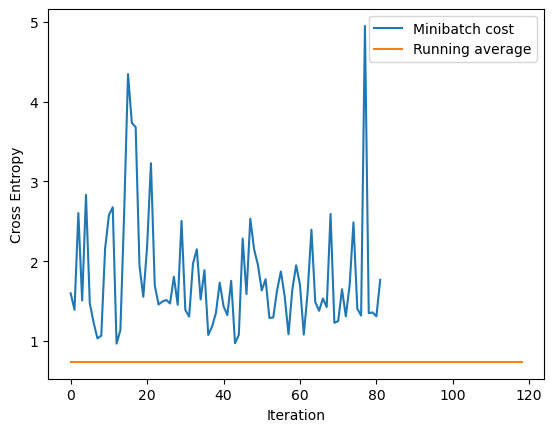

In [26]:
# Training lost plot
plt.plot(cost_list, label='Minibatch cost')
plt.plot(np.convolve(cost_list, 
                     np.ones(200,)/200, mode='valid'), 
         label='Running average')

plt.ylabel('Cross Entropy')
plt.xlabel('Iteration')
plt.legend()
plt.show()

#### Accuracy plot

ValueError: x and y must have same first dimension, but have shapes (10,) and (0,)

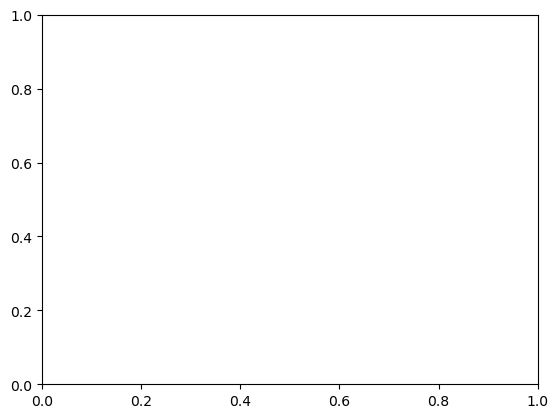

In [27]:
plt.plot(np.arange(1, NUM_EPOCHS+1), train_acc_list, label='Training')
plt.plot(np.arange(1, NUM_EPOCHS+1), valid_acc_list, label='Validation')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#### Confusion matrix

In [28]:
def classify_DR_images(model, data_loader, data_type, device):

    res_label_arr = []
    res_score_arr = []
    for i, (images, labels, paths) in enumerate(data_loader):
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        logits, probas = model(images)
        _, predicted_labels = torch.max(probas, 1)
        res_label_arr.append(predicted_labels.detach().cpu().numpy())
        res_score_arr.append(probas.detach().cpu().numpy())
        if i % 50 == 0:
            print (f'Batch {i:03d}/{len(data_loader):03d} | data type: {data_type}')
        
    res_label_arr = np.concatenate(res_label_arr)
    res_score_arr = np.concatenate(res_score_arr)
    return res_label_arr, res_score_arr

In [29]:
# confusion matrix display
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
def display_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1, 2, 3, 4])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1, 2, 3, 4])
    disp.plot()
    plt.show()

Batch 000/183 | data type: train
Batch 050/183 | data type: train
Batch 100/183 | data type: train
Batch 150/183 | data type: train


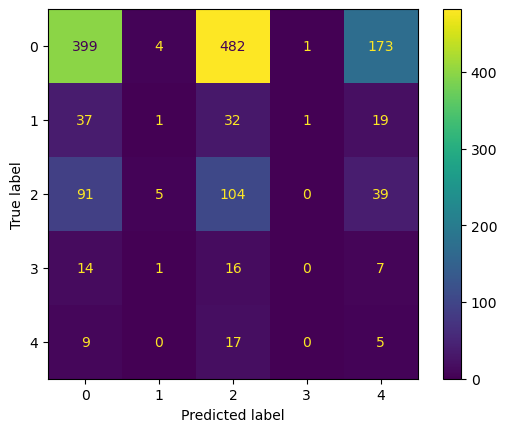

Batch 000/021 | data type: valiation


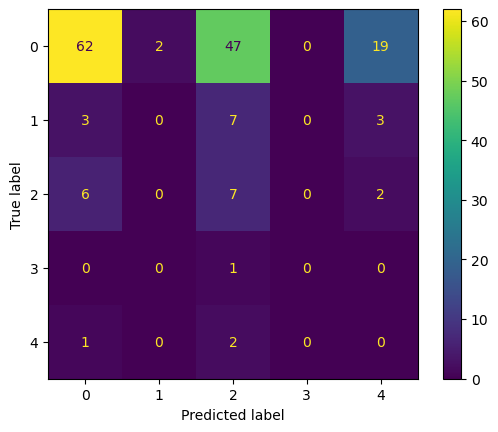

Batch 000/023 | data type: test


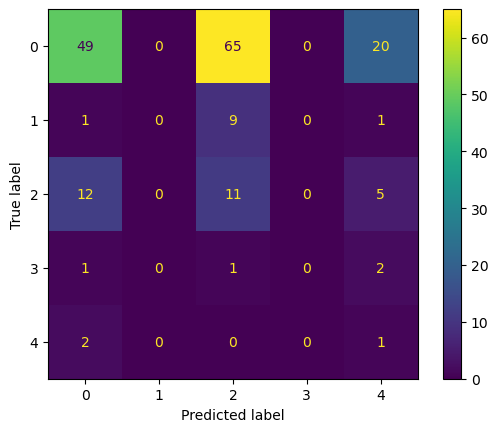

In [30]:
# if mode file existed, load new model
model_file_name = os.path.join('weights', 'DRClassifcation.pth')
if not os.path.exists(model_file_name) or not os.path.isfile(model_file_name):
    print("=> loading check point {model_file_name}")
    checkpoint = torch.load(model_file_name, map_location = torch.device('cpu'))
    model.load_state_dict(checkpoint['state_dict'])
    

# confusion matrix of training results 
y_true_train = train_labels.tolist()
y_pred_train, y_prob_train = classify_DR_images(model, train_loader, 'train', DEVICE)
display_confusion_matrix(y_true_train, y_pred_train)

# confusion matrix of validation results 
y_true_val = val_labels.tolist()
y_pred_val, y_prob_val = classify_DR_images(model, valid_loader, 'valiation', DEVICE)
display_confusion_matrix(y_true_val, y_pred_val)


# confusion matrix of testing results 
y_true_test = test_labels.tolist()
y_pred_test, y_prob_test = classify_DR_images(model, test_loader, 'test', DEVICE)
display_confusion_matrix(y_true_test, y_pred_test)

#### One-vs-Rest ROC Curves

In [41]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import RocCurveDisplay
from itertools import cycle

def display_roc_one_vs_rest(y_true, y_score, display_name):
    fig, ax = plt.subplots(figsize=(6, 6))
    
    label_binarizer = LabelBinarizer().fit([0,1,2,3,4])
    y_onehot_true = label_binarizer.transform(y_true)
    
    colors = cycle(["aqua", "darkorange", "cornflowerblue", "deeppink", "navy"])
    
    for class_id, color in zip(range(5), colors):
        RocCurveDisplay.from_predictions(
            y_onehot_true[:, class_id],
            y_score[:, class_id],
            name=f"ROC curve for {class_id:01d}",
            color=color,
            ax=ax,
        )

    plt.plot([0, 1], [0, 1], "k--", label="ROC curve for chance level (AUC = 0.5)")
    plt.axis("square")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f'Receiver Operating Characteristic\nto One-vs-Rest multiclass for {display_name}')
    plt.legend()
    plt.show()

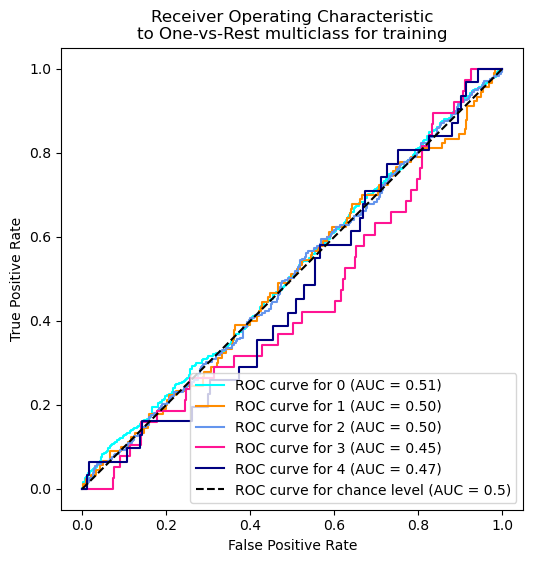

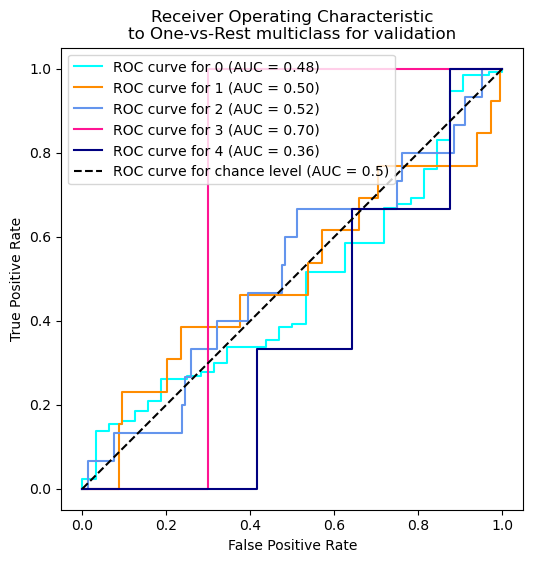

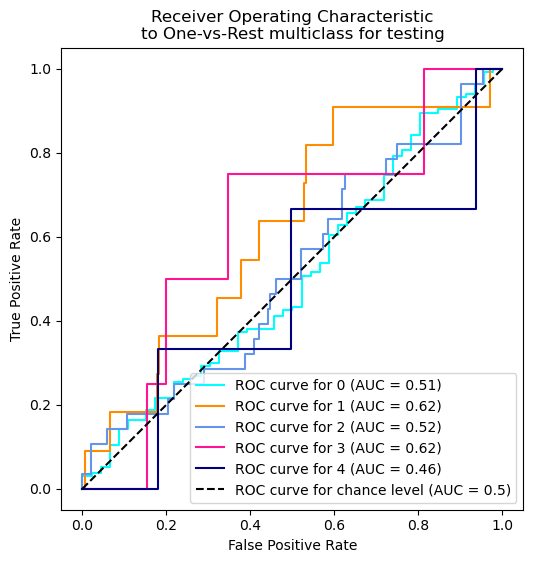

In [42]:
# display ROC curves for training data
display_roc_one_vs_rest(y_true_train, y_prob_train, 'training')

# display ROC curves for validation data
display_roc_one_vs_rest(y_true_val, y_prob_val, 'validation')

# display ROC curves for test data
display_roc_one_vs_rest(y_true_test, y_prob_test, 'testing')

### Summary

* In this work, I demonstrated the usage of DenseNet to classify the level of diabetic retinopathy fundus images.
* The main challenge of this task was the imbalance among four different levels of fundus images, and the weighted cross entropy loss function was utilized to address this issue. 
* Due to lack of computational resource, ROC curves have not reached the best performance (Epochs = 5 in this work). However, the accuracy is continuously increasing during training.
* DenseNet was trained from scratch, and the pretrained ImageNet model weight was not used to initialize DenseNet. This could be included in the future work.